<a href="https://colab.research.google.com/github/krauseannelize/nb-ml-ms-exercises/blob/main/notebooks/04_ml_model_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 | ML Model: Titanic

# Feature Preparation

In this exercise, the Titanic dataset accessible from [Kaggle](https://www.kaggle.com/datasets/yasserh/titanic-dataset) is used to explore how to deal with missing data. To proceed, the .csv dataset is read into Colab as a `pandas` DataFrame.

In [1]:
# Import libraries
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Read Titanic dataset as pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/titanic-raw.csv')

Mounted at /content/drive


In [2]:
# Preview Titanic dataset
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Inspect shape of the dataset
print(f"Dataset shape\nRows: {df.shape[0]}\nColumns: {df.shape[1]}")

Dataset shape
Rows: 891
Columns: 12


In [4]:
# Create a copy of the dataset to commence cleaning
df_clean = df.copy()

## Step 1 | Handling Missing Data

### 1.1 Check for Missing Values

In [5]:
df_clean.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


### 1.2 Dropping Missing Values

As only a negligible percentage (2 of 891 rows) of the values in `Embarked` are missing, they can be dropped.

In [6]:
# Drop rows with missing values in Embarked
df_clean = df_clean.dropna(subset=["Embarked"])

In [7]:
# Confirm there are no missing values left
df_clean["Embarked"].isnull().sum()

np.int64(0)

### 1.3 Imputing Numerical Missing Values

The 177 missing values in `Age` is filled with the median age, which is better at dealing with outliers than mean.

In [8]:
# Replace missing values with Age median value
df_clean.loc[:, "Age"] = df_clean["Age"].fillna(df_clean["Age"].median())

In [9]:
# Confirm there are no missing values left
df_clean["Age"].isnull().sum()

np.int64(0)

### 1.4 Dropping Entire Columns

`Cabin` is missing 77% (687 of 891 rows) of its values, which is too much to impute reliably and the best choice is to drop the column for now.

In [10]:
# Drop column Cabin having too many missing values
df_clean = df_clean.drop(columns=["Cabin"])

In [11]:
# Confirm all missing values have been dealth with successfully
df_clean.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


## Step 2 | Handling Outliers

### 2.1 Visualize Outliers

**Observation:** Most fares are below 100, but a few extreme outliers exist.

<Axes: xlabel='Fare'>

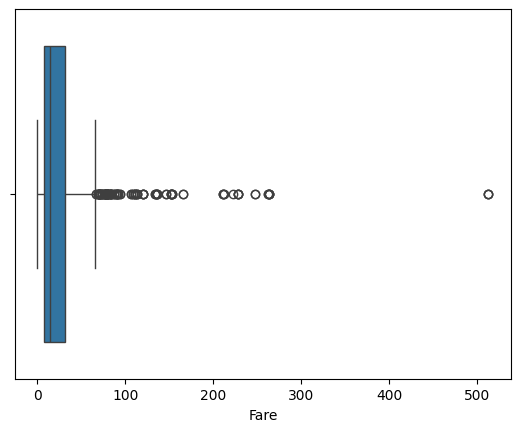

In [12]:
# Import libraries
import seaborn as sns

# Visualize outliers in Fare column with a boxplot
sns.boxplot(x=df_clean["Fare"])

### 2.2 Detect Outliers Using IQR

In [13]:
# Calculate the 1st and 3rd quartiles of the Fare column
Q1 = df_clean["Fare"].quantile(0.25)
Q3 = df_clean["Fare"].quantile(0.75)

# Calculate the interquartile range
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows to view outliers
outliers = df_clean[(df_clean["Fare"] < lower_bound) | (df_clean["Fare"] > upper_bound)]
print(f"Number of outliers in Fare: {len(outliers)}")

Number of outliers in Fare: 114


### 2.3 Removing Outliers

In [14]:
row_cnt_before = df_clean.shape[0]
col_cnt_before = df_clean.shape[1]

# Illustration of how to remove outliers without editing df_clean
df_removed = df_clean[(df_clean["Fare"] >= lower_bound) & (df_clean["Fare"] <= upper_bound)]

# Confirm the number of rows removed
row_cnt_after = df_removed.shape[0]
col_cnt_after = df_removed.shape[1]
print(f"Number of rows removed: {row_cnt_before - row_cnt_after}")

Number of rows removed: 114


### 2.4 Capping Outliers

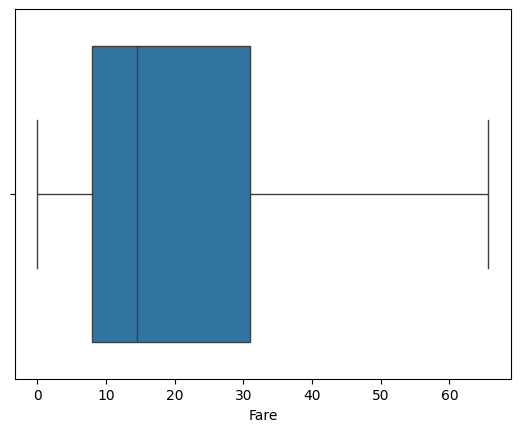

In [15]:
# Ceate a copy to illustrate capping
df_capped = df_clean.copy()

# Use previously defined bounds to cap outliers
df_capped["Fare"] = df_capped["Fare"].clip(lower=lower_bound, upper=upper_bound)

# Visualize capped data - semicolon added to suppress text output
sns.boxplot(x=df_capped["Fare"]);

### 2.5 Transforming (Log-Scaling)

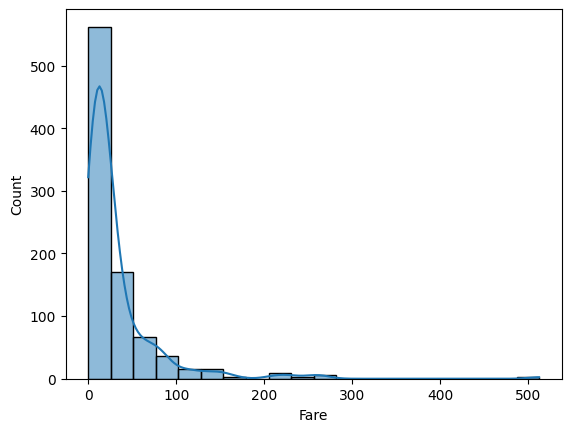

In [16]:
# Visualize how Fare is distributed - semicolon added to suppress text output
sns.histplot(df_clean["Fare"], bins=20, kde=True);

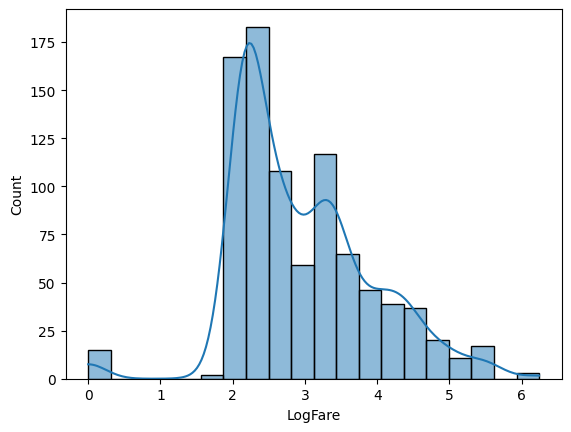

In [17]:
# Import libraries
import numpy as np

# Create new column with log-transformed Fare values
# np.log1p(x) computes log(1 + x), which safely handles zeros and small values
df_clean["LogFare"] = np.log1p(df_clean["Fare"])

# Visualize how LogFare is distributed - semicolon added to suppress text output
sns.histplot(df_clean["LogFare"], bins=20, kde=True);

## Step 3 | Handling Categorical Data

### 3.1 Label Encoding (Binary Category)

In [18]:
# Check different values and distributions in Sex column
df_clean["Sex"].value_counts()

,count
Sex,
male,577
female,312


In [19]:
# Replace male with 0 and female with 1
df_clean["Sex"] = df_clean["Sex"].map({"male": 0, "female": 1})

In [20]:
# Recheck different values and distributions in Sex column
df_clean["Sex"].value_counts()

,count
Sex,
0,577
1,312


### 3.2 OneHotEncoder with `pandas`

In [21]:
# Find unique categories in Embarked column
df_clean["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [22]:
# Transformation using pandas.get_dummies
# `drop_first=True` drops one dummy column - If all other dummy columns are 0,
# the observation must belong to the dropped category
pd.get_dummies(df_clean, columns=["Embarked"], drop_first=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,LogFare,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,2.110213,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,4.280593,False,False
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,2.188856,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,3.990834,False,True
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,2.202765,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,2.639057,False,True
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,3.433987,False,True
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,3.196630,False,True
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,3.433987,False,False


### 3.3 OneHotEncoder with `scikit-learn`

Everything in `scikit-learn` (also `sklearn`) works through a consistent API using **fit**, **transform**, and **predict**. Many preprocessing tools in `sklearn` are called **transformers** that follow the same workflow:

- `.fit()` | Learn something from the data such as which category exist
- `.transform()` | Apply that knowledge to change the data
- `.fit_transform()` | Do both steps in one go

In [23]:
# Import libraries
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder object from `scikit-learn`
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

# Step 1: Use fit to learn which categories exist
encoder.fit(df_clean[["Embarked"]])

# Step 2: Transform creates new columns for each category
embarked_encoded = encoder.transform(df_clean[["Embarked"]])

# Step 3: Create dataframe with encoded columns
embarked_df = pd.DataFrame(embarked_encoded, columns=encoder.get_feature_names_out(["Embarked"]))

# Step 4: Concatenate back with original dataframe
df_encoded = pd.concat([df_clean.reset_index(drop=True), embarked_df], axis=1)

# Preview the first rows of the new dummy columns for 'Embarked'
df_encoded[encoder.get_feature_names_out(["Embarked"])].head()

,Embarked_Q,Embarked_S
0,0.0,1.0
1,0.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


Step 1 (fit) and Step 2 (transform) can be done in one step using the shortcut `.fittransform()`:

```python
embarked_encoded = encoder.fit_transform(df_clean[["Embarked"]])
```

**When to use which method**

| Method | What it does | When to use |
| --- | --- | --- |
| `.fit()` | Learns transformation parameters (mean, std, min, max, etc.) from data | On **training data only** |
| `.transform()` | Applies learned transformation to any dataset (train, test, or new data) | Always use after `.fit()` |
| `.fit_transform()` | Do both steps in one go | Convenient on training data only |

### 3.4 Ordinal Encoding

For `Pclass` (Passenger Class), the values 1, 2, 3 already represent an order (1 = Upper class, 3 = Lower class) thus no transformation needed.

In [24]:
df_clean["Pclass"].unique()

array([3, 1, 2])

## Step 4 | Feature Scaling

### 4.1 Normalization (Min-Max Scaling)

In [25]:
# Summarize to see if it makes sense to scale continuous variables Age and Fare
df_clean[["Age", "Fare"]].describe()

,Age,Fare
count,889.000000,889.000000
mean,29.315152,32.096681
std,12.984932,49.697504
min,0.420000,0.000000
25%,22.000000,7.895800
50%,28.000000,14.454200
75%,35.000000,31.000000
max,80.000000,512.329200


It will be an unfair comparison as `Fare` has a maximum exceeding 500 and `Age` has a max of 80.

In [26]:
# Import libraries
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler (default scales features to range [0, 1])
scaler = MinMaxScaler()

# Make a copy of the DataFrame to manipulate
df_minmax = df_clean.copy()

# Fit the scaler on 'Age' and 'Fare' and transform them into the [0, 1] range
df_minmax[["Age", "Fare"]] = scaler.fit_transform(df_minmax[["Age", "Fare"]])

# Summarize scaled columns to confirm new range and distribution
df_minmax[["Age", "Fare"]].describe()

,Age,Fare
count,889.000000,889.000000
mean,0.363096,0.062649
std,0.163168,0.097003
min,0.000000,0.000000
25%,0.271174,0.015412
50%,0.346569,0.028213
75%,0.434531,0.060508
max,1.000000,1.000000


### 4.2 Standardization (Z-score)

In [27]:
# Import libraries
from sklearn.preprocessing import StandardScaler

# Initialize the scaler (standardizes features to mean=0, std=1)
scaler = StandardScaler()

# Make a copy of the DataFrame to manipulate
df_standard = df_clean.copy()

# Fit the scaler on 'Age' and 'Fare' and transform them to standardized values
df_standard[["Age", "Fare"]] = scaler.fit_transform(df_standard[["Age", "Fare"]])

# Summarize standardized columns (rounded) to confirm mean≈0 and std≈1
df_standard[["Age", "Fare"]].describe().round(2)

,Age,Fare
count,889.00,889.00
mean,0.00,0.00
std,1.00,1.00
min,-2.23,-0.65
25%,-0.56,-0.49
50%,-0.10,-0.36
75%,0.44,-0.02
max,3.91,9.67


## Step 5 | Feature Creation and Transformation

### 5.1 Feature Creation | Family Size

In [28]:
# Preview `SibSp` (sibling/spouse) and `Parch` (parent/children)
df_clean[["SibSp", "Parch"]].head()

,SibSp,Parch
0,1,0
1,1,0
2,0,0
3,1,0
4,0,0


In [29]:
# Add new feature `FamilySize` adding 1 for the passenger
df_clean["FamilySize"] = df_clean["SibSp"] + df_clean["Parch"] + 1

# Preview `SibSp`, `Parch` and new feature `FamilySize`
df_clean[["SibSp", "Parch", "FamilySize"]].head()

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1


### 5.2 Binning | Age Groups

In [30]:
# Summarize which range of values `Age` takes
df_clean["Age"].describe()

,Age
count,889.000000
mean,29.315152
std,12.984932
min,0.420000
25%,22.000000
50%,28.000000
75%,35.000000
max,80.000000


In [31]:
# Create bins and labels
bins = [0, 12, 18, 35, 60, 100]
labels = ["Child", "Teen", "Adult", "MiddleAge", "Senior"]

# In new column `AgeGroup` categorize 'Age' into groups using defined bins and labels
df_clean["AgeGroup"] = pd.cut(df_clean["Age"], bins=bins, labels=labels, right=False)

# Preview new feature `AgeGroup`
df_clean[["Age", "AgeGroup"]].head(10)

,Age,AgeGroup
0,22.0,Adult
1,38.0,MiddleAge
2,26.0,Adult
3,35.0,MiddleAge
4,35.0,MiddleAge
5,28.0,Adult
6,54.0,MiddleAge
7,2.0,Child
8,27.0,Adult
9,14.0,Teen


### 5.3 Extract Information from Strings | Titles

In [32]:
# Preview the `Name` column
df_clean["Name"].head()

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


In [33]:
# Create a new feature `Title` using a regular expression to extract a substring
# The regex r" ([A-Za-z]+)\." means:
# - A space (" ")
# - Followed by one or more letters ([A-Za-z]+)
# - Followed by a literal period (\.)
df_clean["Title"] = df_clean["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)

# Preview how many times each unique `Title` appear showing top 5 only
df_clean["Title"].value_counts().head()

,count
Title,
Mr,517
Miss,181
Mrs,124
Master,40
Dr,7


# Logistic Regression

## Step 0 | Check the Dataset

In [34]:
# Preview the processed dataset
df_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,LogFare,FamilySize,AgeGroup,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S,2.110213,2,Adult,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,4.280593,2,MiddleAge,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S,2.188856,1,Adult,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S,3.990834,2,MiddleAge,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S,2.202765,1,MiddleAge,Mr


### Issues

- `Embarked`, `AgeGroup`, and `Title` are important features, but they’re still text.
- They need to be encoded as models can’t use strings.

### Tasks

- `AgeGroup`: Ordinal/label encode
  - Map the ordered groups to integers (e.g., Child < Teen < Adult < MiddleAge < Senior).
- `Title`: One-hot encode (after grouping rare titles)
  - Title is nominal (no natural order). First merge rare titles into "Other", then one-hot encode.
- `Embarked`: One-hot encode
  - Create numeric columns for each port and add them to the dataframe.

### `AgeGroup` | Ordinal Encoding

In [35]:
# Define a mapping from categorical age groups to numeric codes
agegroup_mapping = {"Child": 0, "Teen": 1, "Adult": 2, "MiddleAge": 3, "Senior": 4}

# Apply mapping to create a new numeric `AgeGroup_num` column
df_clean["AgeGroup_num"] = df_clean["AgeGroup"].map(agegroup_mapping).astype("Int64")

# Preview dataset to confirm new numeric column
df_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,LogFare,FamilySize,AgeGroup,Title,AgeGroup_num
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S,2.110213,2,Adult,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,4.280593,2,MiddleAge,Mrs,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S,2.188856,1,Adult,Miss,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S,3.990834,2,MiddleAge,Mrs,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S,2.202765,1,MiddleAge,Mr,3


### `Title` | Group Rare

In [36]:
# Check different values and distributions in Title column
df_clean["Title"].value_counts()

,count
Title,
Mr,517
Miss,181
Mrs,124
Master,40
Dr,7
Rev,6
Col,2
Mlle,2
Major,2


In [37]:
# Normalize a few aliases
df_clean["Title"] = df_clean["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})

In [38]:
# Count how many times each title appears
title_counts = df_clean["Title"].value_counts()

# Identify titles that occur fewer than 10 times
rare_titles = title_counts[title_counts < 10].index

# Group rare titles into "Other"
df_clean["Title"] = df_clean["Title"].replace(rare_titles, "Other")

# Check the frequency of each title after grouping rare ones
df_clean.Title.value_counts()

,count
Title,
Mr,517
Miss,184
Mrs,125
Master,40
Other,23


### `Embarked` and `Title` | One-Hot Encoding

In [39]:
# Import OneHotEncoder from scikit-learn for categorical encoding
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder object from `scikit-learn`
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

# Subset of columns to be encoded
to_encode = df_clean[["Embarked", "Title"]]

# Use fit_transform to learn which categories exist and create new columns for each category
encoded = encoder.fit_transform(to_encode)

# Put back as DataFrame with new col names
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["Embarked", "Title"]), index=df_clean.index)

# Concatenate original and encoded DataFrames
df_clean = pd.concat([df_clean, encoded_df], axis=1)

# Preview the updated DataFrame after encoding
df_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FamilySize,AgeGroup,Title,AgeGroup_num,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,2,Adult,Mr,2,0.0,1.0,0.0,1.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,2,MiddleAge,Mrs,3,0.0,0.0,0.0,0.0,1.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,...,1,Adult,Miss,2,0.0,1.0,1.0,0.0,0.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,...,2,MiddleAge,Mrs,3,0.0,1.0,0.0,0.0,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,...,1,MiddleAge,Mr,3,0.0,1.0,0.0,1.0,0.0,0.0


### Drop Columns

In [40]:
# Drop columns that are not useful or has been replaced with engineered versions
df_lr = df_clean.drop(columns=[
    "PassengerId",     # ID, no predictive value
    "Name",            # Text field
    "Ticket",          # Mostly random identifiers
    "Fare",            # Dropped to avoid correlation with Pclass
    "Embarked",        # Will use one-hot encoded version
    "Age","AgeGroup",  # Replaced by AgeGroup_num
    "SibSp", "Parch",  # Replaced by FamilySize
    "Title"            # Replaced by one-hot encoding
])

# Preview updated DataFrame to confirm all columns numerical
df_lr.head()

,Survived,Pclass,Sex,LogFare,FamilySize,AgeGroup_num,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,3,0,2.110213,2,2,0.0,1.0,0.0,1.0,0.0,0.0
1,1,1,1,4.280593,2,3,0.0,0.0,0.0,0.0,1.0,0.0
2,1,3,1,2.188856,1,2,0.0,1.0,1.0,0.0,0.0,0.0
3,1,1,1,3.990834,2,3,0.0,1.0,0.0,0.0,1.0,0.0
4,0,3,0,2.202765,1,3,0.0,1.0,0.0,1.0,0.0,0.0


## Step 1 | Split Features (X) and Target (y)

- **Features (X):** Column used to predict survival
- **Target (y):** Column to predict → `Survived`

In [41]:
# Features: all but the target
X = df_lr.drop(columns=["Survived"])

# Target column
y = df_lr["Survived"]

# Quick check to confirm `Survived` not included to prevent data leakage
X.head()

,Pclass,Sex,LogFare,FamilySize,AgeGroup_num,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,3,0,2.110213,2,2,0.0,1.0,0.0,1.0,0.0,0.0
1,1,1,4.280593,2,3,0.0,0.0,0.0,0.0,1.0,0.0
2,3,1,2.188856,1,2,0.0,1.0,1.0,0.0,0.0,0.0
3,1,1,3.990834,2,3,0.0,1.0,0.0,0.0,1.0,0.0
4,3,0,2.202765,1,3,0.0,1.0,0.0,1.0,0.0,0.0


## Step 2 | Split into Train/Test

In [43]:
# Import function to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split features (X) and target (y) into train and test sets
# - test_size=0.2 → 20% of the data goes to the test set
# - random_state=42 → ensures reproducibility of the split
# - stratify=y → keeps the same class distribution in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print the shape of the resulting datasets to verify the split
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (711, 11)
Test size: (178, 11)


## Step 3 | Choose an Algorithm

In [44]:
# Import LogisticRegression model from scikit-learn
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
# - max_iter=1000 → increases the maximum number of iterations so the solver has enough time to converge
# - random_state=42 → ensures reproducibility of results
model = LogisticRegression(max_iter=1000, random_state=42)

# View untrained algorithm object
model

LogisticRegression(max_iter=1000, random_state=42)

## Step 4 | Fit the Model

In [45]:
# Train (fit) the logistic regression model on the training data
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [46]:
# Print the learned coefficients for each feature
# These represent the weight/importance of each input variable
print(model.coef_)

[[-0.77349027  0.85350967  0.42414388 -0.45197942 -0.45304645  0.25033175
  -0.23879833 -0.20697405 -2.22349928  0.26551245 -1.40121963]]


In [47]:
# Print the intercept (bias term) of the model
# This shifts the decision boundary
print(model.intercept_)

[2.84349276]


## Step 5 | Predict with Test Data

### Predict Class Labels (0 or 1)

In [48]:
# Predict class labels 0 (did not survive) or 1 (survived)
y_pred = model.predict(X_test)
print(y_pred[:10])

[0 0 0 0 0 1 0 1 1 0]


### Predict Probabilities

In [49]:
# Predict probability of survival
y_proba = model.predict_proba(X_test)
print(y_proba[:10])

[[0.95249257 0.04750743]
 [0.86855325 0.13144675]
 [0.86855325 0.13144675]
 [0.91461563 0.08538437]
 [0.94445964 0.05554036]
 [0.05720529 0.94279471]
 [0.91546236 0.08453764]
 [0.05699926 0.94300074]
 [0.10660203 0.89339797]
 [0.91469332 0.08530668]]


**Understanding the output:**

- _Column 0:_ probability of class 0 (not survived)
- _Column 1:_ probability of class 1 (survived)

Example:

- _Passenger 1:_ `[0.95, 0.04]` → 4% chance of survival (0)
- _Passenger 9:_ `[0.10, 0.89]` → 89% chance of survival (1)

### Put Everything Together

In [50]:
import pandas as pd

# Create a DataFrame to compare actual vs. predicted results
# - Actual: real survival (0/1)
# - Predicted: class predicted (0/1)
# - Prob_Survived: predicted probability of survival
results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Prob_Survived": y_proba[:, 1]
})

# Preview the comparison
results.head(10)

,Actual,Predicted,Prob_Survived
0,0,0,0.047507
1,0,0,0.131447
2,0,0,0.131447
3,0,0,0.085384
4,0,0,0.055540
5,0,1,0.942795
6,0,0,0.084538
7,1,1,0.943001
8,1,1,0.893398
9,1,0,0.085307


Here we can:

- spot cases where the model was confident (probabilities close to 0 or 1), and
- spot borderline cases (probabilities around 0.5).

### Toggle the Threshold (0.5 → 0.3 → 0.7) and Compare

- **Logistic Regression** uses a `0.5 threshold` by default.
- Manually set it to `0.3 threshold` so the model will now be more likely to predict survival (because it only needs 30% confidence instead of 50%).
- A higher `0.7 threshold` would be stricter with higher preciion and fewer false alarms, but would also miss more survivors.

In [51]:
# Get probabilities for class 1
y_prob = model.predict_proba(X_test)[:, 1]

# Manually apply your threshold
threshold = 0.3
y_pred_custom = (y_prob >= threshold).astype(int)

## Step 6 | Evaluate

In [52]:
from sklearn.metrics import accuracy_score

# Compare true values (y_test) vs predicted values (y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

Accuracy: 0.8146067415730337


The model correctly predicted survival for 81% of passengers in the test set.